# [프로젝트] Code Interpreter를 이용한 데이터 분석 및 차트 제너레이터 Agent

랭체인의 Code Interpreter를 이용해, 주어진 파일의 데이터를 분석하는 에이전트를 만들어 보겠습니다.   

사용자의 질의와 파일 경로를 받아, 시각화 아이디어를 구상하고 이를 통해 파이썬 코드를 작성해 실행합니다.

In [ ]:
!pip install plotly seaborn langgraph langchain langchain_google_genai langchain_experimental google_generativeai langchain_community python-dotenv -q

이번 실습에서는 한국어 시각화를 위해 `koreanize_matplotlib`를 사용합니다.
실제로 활용할 때에는, OS의 환경에 맞게 수정하시면 됩니다.

In [ ]:
!pip install koreanize_matplotlib

In [ ]:
import os
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import Dict, Any, Optional, Tuple

# 환경 변수 로드
load_dotenv()


os.environ['LANGCHAIN_PROJECT'] = 'LangGraph_FastCampus'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_TRACING_V2']='true'


llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0.5)


파일 경로와 질문이 주어지면, 시각화 아이디어를 제공하는 노드를 구성합니다.

In [ ]:
from langchain_experimental.utilities import PythonREPL
from langchain_core.tools import tool
from typing import Annotated


repl = PythonREPL()

In [ ]:
# 툴 정보를 보다 자세하게 작성하여 성능을 높입니다.
# LangGraph의 기본 표현을 사용했습니다!
@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return result_str

데이터를 분석하기 전, 기본적인 정보는 필요합니다.

data_prepare_agent를 react agent로 구성합니다.

In [ ]:
from langgraph.prebuilt import create_react_agent
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage
from typing import List, Optional, Dict, Any, Union, Annotated, TypedDict, Literal
from pydantic import BaseModel, Field
# query와 messages를 저장


# Chart Agent 프롬프트
data_prepare_agent = create_react_agent(llm, [python_repl_tool],
    prompt="""python_repl을 사용해, 주어진 파일을 간단히 분석하세요.

다음의 순서로 실행하세요.
1. 해당 파일을 읽고, 컬럼 이름을 파악하세요.
2. 파악한 결과를 바탕으로, 개략적인 통계 자료를 출력하세요.
주로 다음과 같은 항목이 포함됩니다:
행과 열의 개수
예시 데이터

실패하는 경우, 적절한 인코딩 방식을 활용하여 재시도하세요."""
)

def prepare_data(state:State):
    messages=[(HumanMessage(f"파일 경로는 f{state['file_path']} 입니다."))]
    file_path = state['file_path']
    code_result = data_prepare_agent.invoke({'messages':[HumanMessage(f'파일 경로:{file_path}')]})
    first_analysis = code_result['messages'][-1].content
    return {'first_analysis':first_analysis}



In [ ]:
from langchain.prompts import ChatPromptTemplate


# 시각화 기획자 에이전트
planner_prompt = ChatPromptTemplate(["""
당신은 데이터 시각화 전문가로 사용자가 제공한 데이터와 요청을 분석하여 최적의 시각화 전략을 수립하는 역할을 맡고 있습니다.

## 데이터 정보:
{first_analysis}

## 사용자 쿼리:
{query}

## 당신의 임무:
1. 데이터 파일을 분석하고 구조와 주요 변수를 파악하세요.
2. 사용자 쿼리의 의도를 명확히 파악하세요.
3. 데이터와 쿼리를 바탕으로 가장 적합한 시각화 유형(막대 그래프, 산점도, 히트맵 등)을 결정하세요.
4. 시각화를 위한 상세 계획을 작성하세요.

## 응답 형식:
다음 섹션을 포함한 계획서를 작성해주세요:
1. 데이터 분석: 데이터 구조, 주요 변수, 특징 등을 설명
2. 사용자 의도 분석: 사용자가 무엇을 알고 싶어하는지 분석
3. 시각화 전략: 어떤 시각화가 적합한지와 그 이유
4. 구체적인 요청사항:
   - 차트 유형
   - 사용할 변수
   - 색상 테마 (필요시)
   - 강조할 부분
   - 제목 및 레이블 제안
   - 기타 특별 요청사항

이 계획서는 시각화 개발자가 실제 코드를 작성하는 데 사용될 것입니다.
"""])


def generate_visualization_idea(state:State):
    chain = planner_prompt | llm
    response = chain.invoke(state)
    return {'planner_request':response.content}


In [ ]:
developer_prompt = ChatPromptTemplate(["""
당신은 데이터 시각화 개발자로서, 시각화 기획자가 제공한 계획에 따라 Python 코드를 작성하여 데이터를 시각화하는 역할을 맡고 있습니다.

## 데이터 파일 경로:
{file_path}


## 데이터의 일부 정보

{first_analysis}

## 시각화 기획자의 요청사항:
{planner_request}

## 평가자의 추가 요청사항:
{evaluation}

## 당신의 임무:
1. 제공된 데이터 파일을 로드하는 코드를 작성하세요.
2. 시각화 기획자의 요청사항에 따라 적절한 시각화 라이브러리(matplotlib, seaborn, plotly 등)를 사용하여 코드를 작성하세요.
3. 시각화 결과를 생성하고 저장하는 코드를 작성하세요.
4. 코드에 대한 설명과 시각화 결과에서 발견된 주요 인사이트를 제공하세요.

작성에서 매우 중요한 규칙은 다음과 같습니다.
한글 데이터가 주로 주어지므로, koreanize_matplotlib 라이브러리를 항상 import하세요.
koreanize_matplotlib는 import만 하면 됩니다. 별도의 실행은 필요하지 않습니다.

매 시각화에는 vis_(number).png 파일로 저장하는 코드를 추가하세요.

number의 값은 현재 폴더(./)에서의 순차적 검색을 통해, 현재 존재하지 않는 가장 작은 자연수로 합니다
(Ex: 이미 vis1.png, vis2.png가 있는 경우 vis3.png에 저장)"""])
# 디버깅이 잘 안 되면, 실제 코드 스니펫을 추가하는 방법도 좋음


def execute_visualization(state:State):
    chain  = developer_prompt | llm
    response = chain.invoke(state)

    def parse(code):
        if '```' in code:
            code = code.split('```python')[1].split('```')[0]
        return code
    code_to_execute = parse(response.content)
    print('### CODE')
    print(code_to_execute)
    print('###')
    return {'code':code_to_execute}


In [ ]:
evaluator_prompt = ChatPromptTemplate(["""
당신은 데이터 시각화 평가 전문가로서, 생성된 시각화가 사용자의 원래 의도와 요구사항을 얼마나 잘 충족시키는지 평가하는 역할을 맡고 있습니다.

## 원래 사용자 쿼리:
{query}

## 원래 시각화 계획:
{planner_request}

## 개발자가 작성한 코드 및 설명:
{code}

## 당신의 임무:
1. 생성된 시각화가 사용자의 원래 의도와 요구사항을 얼마나 잘 충족시키는지 평가하세요.
2. 시각화의 강점과 약점을 분석하세요.
3. 개선이 필요한 부분이 있는지 확인하고, 필요하다면 구체적인 개선 방향을 제시하세요.
4. 시각화 결과물 위주로 평가하세요. 파일 저장이나, 사용자 입력 등은 고려하지 마세요.

## 응답 형식:
다음 항목을 포함한 평가서를 작성해주세요:
1. 종합 평가: 시각화가 사용자 요구사항을 얼마나 잘 충족시키는지에 대한 종합적인 평가
2. 강점: 시각화의 긍정적인 측면
3. 개선점: 보완이 필요한 부분
4. 개선 제안: 구체적인 개선 방향 및 추가 시각화 제안 (필요시)
5. 최종 결정: 다음 중 하나를 선택
   - COMPLETE: 시각화가 충분히 좋으며 더 이상의 개선이 필요 없음
   - REVISE: 개선이 필요하며 구체적인 수정 사항 제시

개선이 필요한 경우, 시각화 개발자에게 전달할 구체적인 수정 요청을 포함해주세요.
"""])

class evaluationState(BaseModel):
    comment: str = Field(description="시각화에 대한 전체 평가 내용")
    decision: Literal['COMPLETE', 'REVISE'] = Field(description='평가에 대한 최종 결정')

def evaluate_visualization(state:State):
    chain = evaluator_prompt | llm.with_structured_output(evaluationState)
    response = chain.invoke(state)
    print('### Evaluation')
    print(response.comment)
    print('### RESULT:', response.decision)
    return {'evaluation':response.comment,
            'decision':response.decision}


In [ ]:
import os
from PIL import Image
import base64
import contextlib
import io

finalize_prompt = ChatPromptTemplate([


    ('system',"""
데이터 파일에 대한 사용자의 질문이 주어집니다.
해당 질문의 결과물로 이미지와 인사이트가 주어졌습니다.

해당 내용을 바탕으로, 전체 보고서를 작성하세요."""),
    ('human', [
        {'type':'text', "text":'''
질문: {query}

인사이트: {insight}'''},
{"type": "image_url", "image_url": {"url": "data:image/jpeg;base64,{image_data}"}}])])


def finalize_output(State):
    # 실행 전 파일 목록 저장
    before_files = set(os.listdir("./"))

    output_capture = io.StringIO()

    # exec 실행 및 출력 저장
    with contextlib.redirect_stdout(output_capture):
        print(result['code'])
        try:
            exec(result['code'])
        except:
            print('### 코드 실행 중 오류 발생 ###')
            print(result['code'])
        return {'final_insight':[], 'img': []}
    observation = output_capture.getvalue()

    # 실행 후 파일 목록 저장
    after_files = set(os.listdir("./"))

    # 새로 추가된 파일 찾기
    new_files = after_files - before_files

    if new_files:
        new_file = new_files.pop()  # 새로 생긴 파일명
        image_path = f"./{new_file}"
        img = Image.open(image_path)
        buffer = io.BytesIO()
        img.save(buffer, format='PNG')  # 이미지 포맷은 필요에 따라 수정 가능
        img_data = base64.b64encode(buffer.getvalue()).decode('utf-8')

    chain = finalize_prompt | llm
    final_insight = chain.invoke(
        {
            'query':state['query'],
            'insight':observation,
            'image_data':img_data
        }
    ).content
    return {'final_insight':[final_insight], 'img': [img_data]}

In [ ]:
def get_next(state:State):
    if state['decision'] == 'COMPLETE':
        return 'END'
    else:
        return 'REVISE'

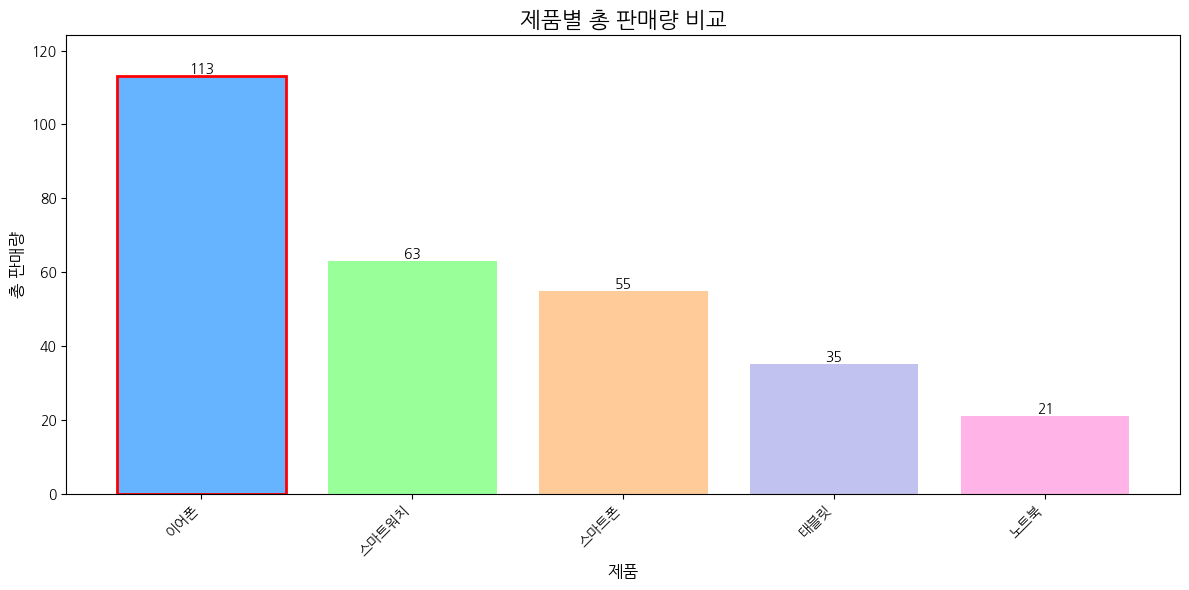

In [ ]:
from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    query : str
    first_analysis : str
    planner_request : str
    file_path : str
    code : str
    evaluation : str
    decision : str
    final_insight : list[str]
    img : list[str]

builder = StateGraph(State)
builder.add_node(prepare_data)
builder.add_node(generate_visualization_idea)
builder.add_node(execute_visualization)
builder.add_node(evaluate_visualization)
builder.add_node(finalize_output)

builder.add_edge(START, 'prepare_data')
builder.add_edge('prepare_data','generate_visualization_idea')
builder.add_edge('generate_visualization_idea','execute_visualization')
builder.add_edge('execute_visualization', 'evaluate_visualization')
builder.add_conditional_edges('evaluate_visualization',
                              get_next,
                              {'REVISE':'execute_visualization',
                               'END':'finalize_output'})
graph = builder.compile()

# graph

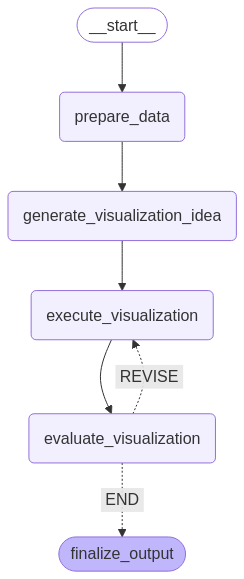

In [ ]:
graph

### Evaluation
시각화가 사용자 요구사항을 잘 충족시키고 있습니다. 막대 그래프를 통해 제품별 총 판매량을 효과적으로 비교하고 있으며, 최다 판매 제품을 강조하여 사용자가 원하는 정보를 쉽게 파악할 수 있도록 했습니다. 제목, 축 레이블, 색상 등 시각적 요소도 적절하게 사용되었습니다. 테이블 형태로 제품별 총 판매량을 추가적으로 제공하여 사용자가 더 자세한 정보를 얻을 수 있도록 한 점도 긍정적입니다.
### RESULT: COMPLETE
파일 분석 결과:

*   **컬럼 이름:** `['날짜', '제품', '가격', '판매량', '고객_연령', '고객_성별', '지역']`
*   **행 개수:** 25
*   **열 개수:** 7
*   **샘플 데이터:**

```
           날짜   제품       가격  판매량  고객_연령 고객_성별  지역
0  2023-01-01  노트북  1200000    5     34    남성  서울
1  2023-01-02  노트북  1200000    3     42    여성  부산
2  2023-01-03  노트북  1200000    2     28    남성  대구
3  2023-01-04  노트북  1200000    7     45    여성  인천
4  2023-01-05  노트북  1200000    4     31    남성  광주
```
### Evaluation
## 시각화 평가서

**1. 종합 평가:**

제공된 시각화는 사용자의 원래 쿼리인 '제품별 총 판매량은 얼마인가?'에 대한 답변을 효과적으로 제공합니다. 막대 그래프는 제품별 판매량을 비교하기에 적합하며, 판매량 순으로 정렬되어 있어 사용자가 제품별 판매량 순위를 쉽게 파악할 수 있습니다. 색상 구분, 제목, 축 레이블 등 시각적 요소도 전반적으로 잘 구성되어 있습니다. 다만, 몇 가지 개선점을 통해 시각화의 완성도를 더욱 높일 수 있습니다.

**2. 강점:**

*   **적절한 시각화 유형:** 막대 그래프를 사

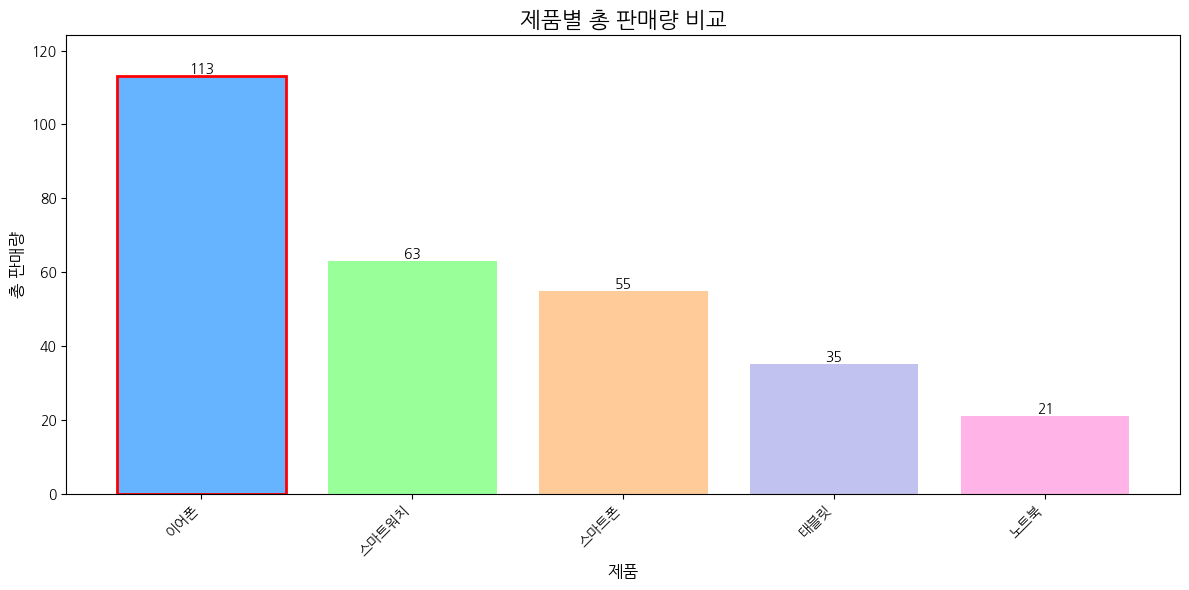

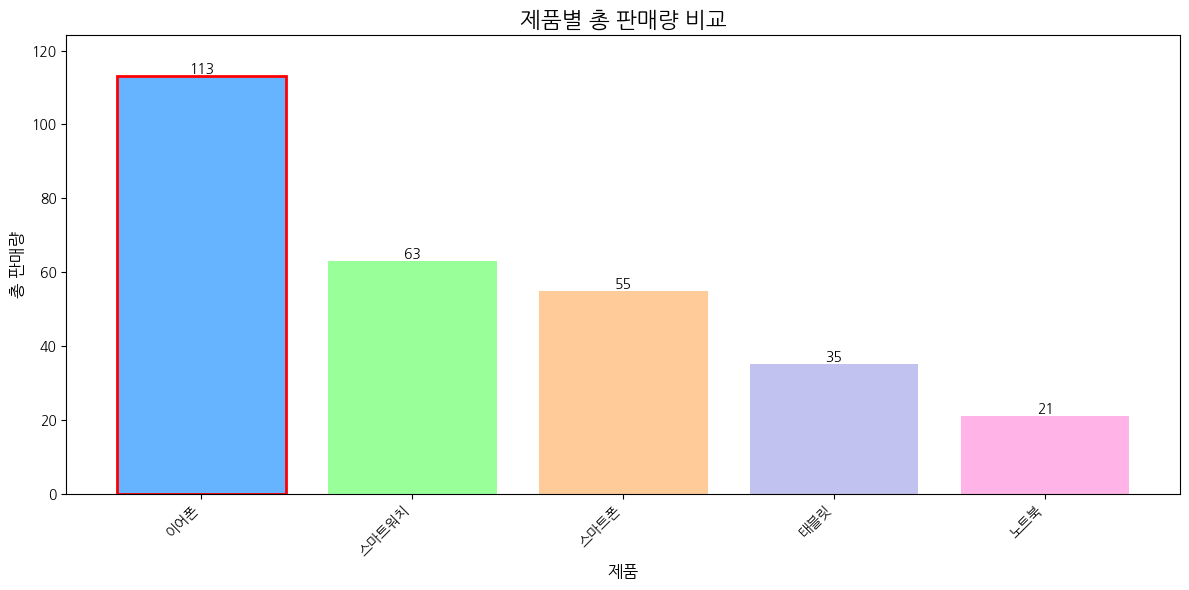

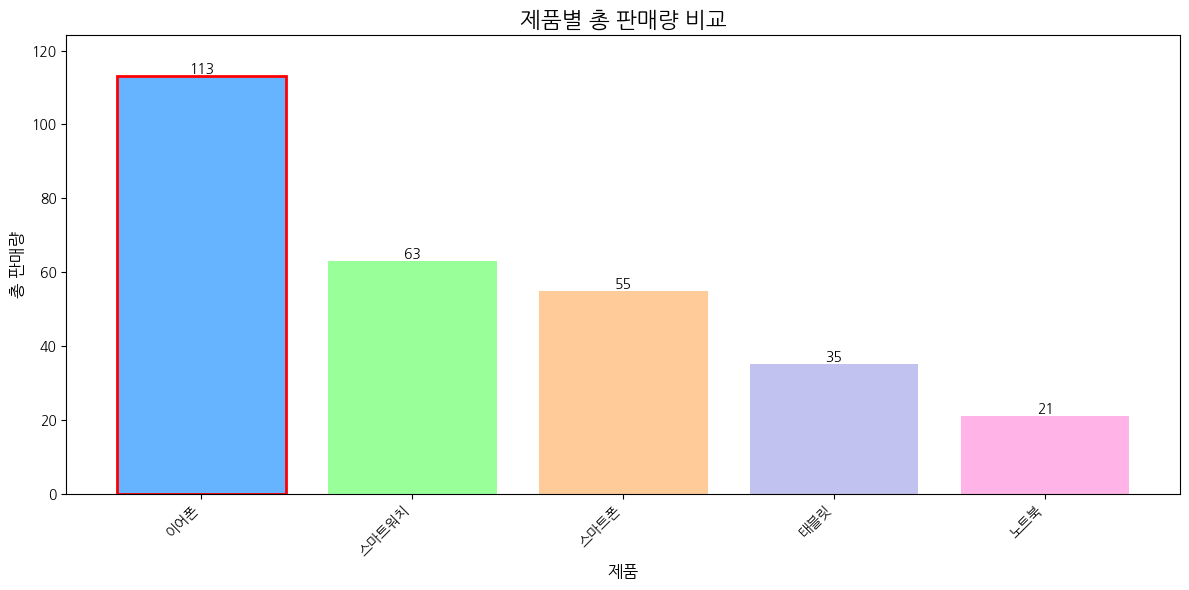

In [ ]:
initial_state = {
    'file_path':'sample_data.csv',
    'query':'이 파일의 제품별 판매량을 비교해줘.',
    'evaluation':''
}

result = graph.invoke(initial_state, {'recursion_limit':250})

해당 기능은 하나의 질문에 대해 시각화를 수행합니다.   
전체 그래프를 하나의 서브노드로 만들고, 질문이 주어지면 이를 여러 개의 파생 질문으로 분리하도록 만들어 보겠습니다.

In [ ]:
from langgraph.graph import StateGraph, START, END

# SubState 형태로 구성 : Prepare Data는 빼기
class State(TypedDict):
    query : str
    first_analysis : str
    planner_request : str
    file_path : str
    code : str
    evaluation : str
    decision : str
    final_insight : list[str]
    img : list[str]

builder = StateGraph(State)
builder.add_node(generate_visualization_idea)
builder.add_node(execute_visualization)
builder.add_node(evaluate_visualization)
builder.add_node(finalize_output)

builder.add_edge(START, 'generate_visualization_idea')
builder.add_edge('generate_visualization_idea','execute_visualization')
builder.add_edge('execute_visualization', 'evaluate_visualization')
builder.add_conditional_edges('evaluate_visualization',
                              get_next,
                              {'REVISE':'execute_visualization',
                               'END':'finalize_output'})

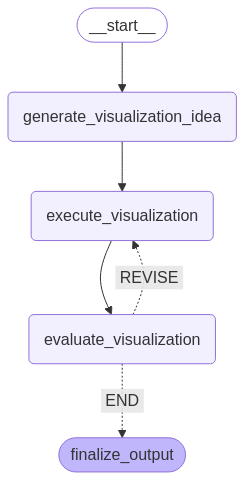

In [ ]:
subgraph = builder.compile()
subgraph

In [ ]:
import operator
from langgraph.constants import Send

class BState(TypedDict):
    query : str
    final_insight : list[str, operator.add]
    img : list[str, operator.add]
    file_path : str
    first_analysis: str
    queries : list[str]


generate_queries_prompt=ChatPromptTemplate(["""
당신은 데이터 분석 전문가입니다.
사용자의 질문에 대한 해답을 얻기 위해,
해당 질문을 보다 자세하고 서로 겹치지 않는 여러 개의 파생 질문으로 분리하세요.

## 데이터 정보:
{first_analysis}

## 사용자 쿼리:
{query}

"""])

class queries(BaseModel):
    queries: list[str] = Field(description="파생 질문 목록")



def generate_queries(state:BState):
    chain = generate_queries_prompt | llm.with_structured_output(queries)
    response = chain.invoke(state).queries
    return {'queries':response}


def assign_workers(state: BState):
    # Send: 노드를 호출하며, 값을 전달해 준다
    # state['contents']의 개수를 기본적으로 알 수 없는데,
    # 이를 통해 개수만큼 llm_call을 생성하여 호출할 수 있음

    return [Send("answer_indiv_question", {"query": s, 'evaluation':'',  'file_path':state['file_path'], 'first_analysis':state['first_analysis']}) for s in state["queries"]]

Prepare Data는 모든 작업에서 동시에 진행하므로 큰 라이브러리로 옮겨 줍니다.

In [ ]:
# Chart Agent 프롬프트
data_prepare_agent = create_react_agent(llm, [python_repl_tool],
    prompt="""python_repl을 사용해, 주어진 파일을 간단히 분석하세요.

다음의 순서로 실행하세요.
1. 해당 파일을 읽고, 컬럼 이름을 파악하세요.
2. 파악한 결과를 바탕으로, 개략적인 통계 자료를 출력하세요.
주로 다음과 같은 항목이 포함됩니다:
행과 열의 개수
예시 데이터

실패하는 경우, 적절한 인코딩 방식을 활용하여 재시도하세요."""
)



def prepare_data(state:BState):
    messages=[(HumanMessage(f"파일 경로는 f{state['file_path']} 입니다."))]
    file_path = state['file_path']
    code_result = data_prepare_agent.invoke({'messages':[HumanMessage(f'파일 경로:{file_path}')]})
    first_analysis = code_result['messages'][-1].content
    return {'first_analysis':first_analysis}


In [ ]:
builder2 = StateGraph(BState)
builder2.add_node(prepare_data)
builder2.add_node('answer_indiv_question', graph)
builder2.add_node(generate_queries)

#builder2.add_node('prepare_data')

builder2.add_edge(START, 'prepare_data')
builder2.add_edge('prepare_data','generate_queries')
#builder2.add_edge(START, 'generate_queries')
builder2.add_conditional_edges("generate_queries", assign_workers, ["answer_indiv_question"])

서브그래프가 포함된 구조는 아래와 같이 xray 설정으로 표시합니다.

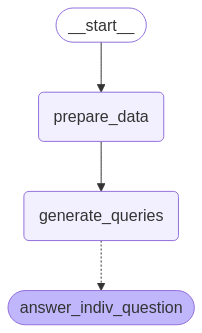

In [ ]:
big_graph

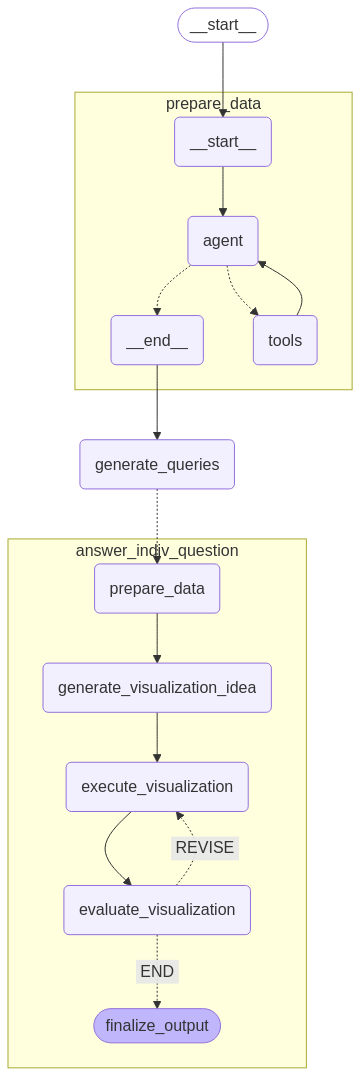

In [ ]:
big_graph = builder2.compile()

from IPython.display import Image, display
display(Image(big_graph.get_graph(xray=1).draw_mermaid_png()))

In [ ]:
initial_state = {
    'file_path':'sample_data.csv',
    'query':'이 파일의 제품별 판매량을 비교해줘.',
    'evaluation':''
}

result = big_graph.invoke(initial_state, {'recursion_limit':250})

파일 분석 결과:

*   **컬럼 이름**: `['날짜', '제품', '가격', '판매량', '고객_연령', '고객_성별', '지역']`
*   **행 개수**: 25
*   **열 개수**: 7
*   **예시 데이터**:

```
           날짜   제품       가격  판매량  고객_연령 고객_성별  지역
0  2023-01-01  노트북  1200000    5     34    남성  서울
1  2023-01-02  노트북  1200000    3     42    여성  부산
2  2023-01-03  노트북  1200000    2     28    남성  대구
3  2023-01-04  노트북  1200000    7     45    여성  인천
4  2023-01-05  노트북  1200000    4     31    남성  광주
```
파일 분석 결과:

*   **행 수:** 25
*   **열 수:** 7
*   **컬럼 이름:** \['날짜', '제품', '가격', '판매량', '고객\_연령', '고객\_성별', '지역']
*   **예시 데이터:**

```
           날짜   제품       가격  판매량  고객_연령 고객_성별  지역
0  2023-01-01  노트북  1200000    5     34    남성  서울
1  2023-01-02  노트북  1200000    3     42    여성  부산
2  2023-01-03  노트북  1200000    2     28    남성  대구
3  2023-01-04  노트북  1200000    7     45    여성  인천
4  2023-01-05  노트북  1200000    4     31    남성  광주
```
파일 분석 결과:

*   **컬럼 이름:** \['날짜', '제품', '가격', '판매량', '고객\_연령', '고객\_성별', '지역']
*   **행 개수:** 25
*   **열 개수:** 7
*   **예시 데이터:**



<string>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



### Evaluation
전반적으로 시각화 계획에 부합하게 잘 구현되었습니다. 막대 그래프를 사용하여 제품별 판매량을 효과적으로 비교하고 있으며, 가장 높은 판매량을 기록한 제품을 강조하여 시각적인 효과를 높였습니다. 제목, 축 레이블, 데이터 레이블 등 필요한 요소들이 모두 포함되어 있으며, 레이블 겹침 문제도 해결되었습니다. 다만, 몇 가지 개선점을 통해 시각화의 완성도를 더욱 높일 수 있습니다.
### RESULT: REVISE
### CODE

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
import os

# 1. 데이터 로드
try:
    df = pd.read_csv("sample_data.csv")
except FileNotFoundError:
    print("Error: sample_data.csv 파일을 찾을 수 없습니다.")
    exit()

# 2. 데이터 전처리: 제품별 총 판매량 계산
product_sales = df.groupby('제품')['판매량'].sum().reset_index()
product_sales = product_sales.sort_values(by='판매량', ascending=False)

# 3. 시각화
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='제품', y='판매량', data=product_sales, palette="viridis")

# 가장 높은 판매량을 기록한 제품 강조
max_sales_product = product_sales.loc[product_sales['판매량'].idxmax(), '제품']
for i, p in enumerate(ax.patches):
    if product_sales['제품'].iloc[i] == max_sales_product:
        p.set_color('red') 

<string>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



### Evaluation
## 시각화 평가서

**1. 종합 평가:**

제공된 막대 그래프는 사용자의 원래 쿼리인 '제품별 총 판매량은 얼마인가?'에 대한 답을 효과적으로 시각화했습니다. 각 제품의 판매량을 비교하고, 가장 많이 팔린 제품을 강조하는 등 사용자 의도를 잘 반영했습니다. 데이터 레이블 추가, 정렬, 툴팁과 같은 추가적인 요청 사항도 대부분 만족스럽게 구현되었습니다.

**2. 강점:**

*   **명확한 시각화:** 막대 그래프를 사용하여 제품별 판매량을 직관적으로 비교할 수 있습니다.
*   **핵심 정보 강조:** 가장 높은 판매량을 기록한 제품을 빨간색으로 강조하여 시각적인 주목도를 높였습니다.
*   **데이터 레이블:** 각 막대 위에 판매량 값을 표시하여 정확한 수치를 쉽게 확인할 수 있도록 했습니다.
*   **정렬:** 판매량 기준으로 내림차순 정렬하여 정보의 우선순위를 효과적으로 전달합니다.
*   **적절한 제목 및 레이블:** 차트 제목과 축 레이블이 명확하게 설정되어 있어 이해하기 쉽습니다.

**3. 개선점:**

*   **색상 팔레트:** viridis 팔레트는 정보 전달에 효과적이지만, 모든 사용자에게 최적의 선택은 아닐 수 있습니다. 색상 대비가 약한 경우 시각적 구분이 어려울 수 있습니다.
*   **X축 레이블 가독성:** 제품 이름이 긴 경우 x축 레이블이 겹쳐 보일 수 있습니다.

**4. 개선 제안:**

*   **색상 팔레트 변경:** 더 직관적인 색상 팔레트(예: 'Set2', 'Pastel1' 등)를 사용하거나, 사용자가 직접 색상을 선택할 수 있도록 옵션을 제공하는 것을 고려해볼 수 있습니다. 색약 사용자를 위한 접근성을 고려하여 색상 조합을 선택하는 것이 좋습니다.
*   **X축 레이블 개선:** x축 레이블이 겹치는 문제를 해결하기 위해 다음과 같은 방법을 고려할 수 있습니다.
    *   레이블 각도 조정: 현재 45도 회전 외에 90도 회전 또는 수직으로 표시하는 것을 시도해볼 수 